In [1]:
from dateutil.parser import parse
import pandas as pd
import datetime
import numpy as np
import statsmodels.api as sm
from numpy import NaN 
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [6]:
path_factor1 = r'C:\Users\ciiad\Smartbeta_Strategy\Factor.xlsx'
path_data = r'C:\Users\ciiad\Smartbeta_Strategy\코스피재무.xlsx'
path_price = r'C:\Users\ciiad\Smartbeta_Strategy\코스피가격.xlsx'
path_index = r'C:\Users\ciiad\Smartbeta_Strategy\인덱스.xlsx'
path_ray = r'C:\Users\ciiad\Smartbeta_Strategy\레이달리오.xlsx'
path_hedge = r'C:\Users\ciiad\Smartbeta_Strategy\헤지용.xlsx'

In [7]:
path_data2 = r'C:\Users\ciiad\Smartbeta_Strategy\코스닥재무.xlsx'
path_price2 = r'C:\Users\ciiad\Smartbeta_Strategy\코스닥가격.xlsx'

In [8]:
def preprocessing(path_data, backtest = False) :
    
    data = pd.read_excel(path_data, index_col=0).iloc[7:]
    data = data[list(data.columns[0:1]) + list(data.columns[3:4]) + list(data.columns[5:])]
    data.columns = data.iloc[0]
    data = data.iloc[1:]  
    
    len_financial_data = len(np.unique(np.array(data[data.columns[1]])))
    only_data = np.array(data[list(data.columns[2:])])
    len_time_data = len(list(data.columns)[2:]) 
    row_num = int(len_financial_data * len_time_data)
    col_num = int(len(data) / len_financial_data)
    financial_data = pd.DataFrame(only_data.reshape(col_num, row_num))
    
    a = list(np.array(list(data[data.columns[1]].iloc[:len_financial_data]) * len_time_data).reshape(len_time_data, -1).T.reshape(-1))  
        
    financial_data.columns = a
    index_name = pd.DataFrame(np.array(data.index).reshape(len(financial_data), len_financial_data))[0]
    financial_data.index = index_name
    financial_data.index.name = ''
    financial_data['총자본(천원)'] = financial_data['총자본(천원)'].fillna(axis = 1, method = 'ffill', limit = 2).fillna(axis = 1, method = 'bfill', limit = 1)
    financial_data['총부채(천원)'] =financial_data['총부채(천원)'].fillna(axis = 1, method = 'ffill', limit = 2).fillna(axis = 1, method = 'bfill', limit = 1)
    financial_data['총자산(천원)'] =financial_data['총자산(천원)'].fillna(axis = 1, method = 'ffill', limit = 2).fillna(axis = 1, method = 'bfill', limit = 1)
    financial_data['수정배당수익률(보통주,현금+주식)(%)'] =financial_data['수정배당수익률(보통주,현금+주식)(%)'].fillna(axis = 1, method = 'ffill', limit = 2).fillna(axis = 1, method = 'bfill', limit = 1)

    Quarter = []
    year = []
    for i in data.columns[2:] :
        Quarter.append( int ( (int(str(i).split('-')[1])+2) /3 ) )
        year.append(  str(i).split('-')[0][-2:]  )

    lst = []
    for i, j in zip(year, Quarter) :
        lst.append(i + '/' +str(j) + 'Q')        
    my_Quarter = pd.DataFrame( (len_financial_data) * lst).T
    my_Quarter.index = ['']
    my_Quarter.columns = list(financial_data.columns)
    
    dumy = pd.DataFrame([''], index= [''] , columns=[data.columns[0]])        
    Q = pd.concat([dumy, my_Quarter], axis =1)
    Symbol_name = pd.DataFrame(list(np.array(data[data.columns[0]]).reshape(len(financial_data), len_financial_data)[:,0]) , columns= [data.columns[0]], index = financial_data.index)
    
    financial_data2 = pd.concat([Symbol_name, financial_data], axis = 1)
    combined = pd.concat([Q, financial_data2], axis = 0)
    l = pd.DataFrame(np.array(combined[combined.columns[1]].iloc[[0]]))

    #백테스트 말고 실제 투자용으로 쓰는 경우 최근 3분기 수익데이터 가중평균하여 연율화
    if backtest == False :
        alpha , beta, gamma = 0.5, 0.3, 0.2
        recent_income = (alpha * combined['당기순이익(연율화)(천원)'].iloc[1:] +
                         beta * combined['당기순이익(연율화)(천원)'].iloc[1:].shift(axis = 1) +
                         gamma * combined['당기순이익(연율화)(천원)'].iloc[1:].shift(2,axis = 1) )/3
        ROA = pd.concat([l, pd.DataFrame(np.array(recent_income)/  np.array(combined['총자산(천원)'].iloc[1:] + 0.00001))], axis = 0)    
    else :
        ROA = pd.concat([l, pd.DataFrame(np.array(combined['당기순이익(연율화)(천원)'].iloc[1:])/  np.array(combined['총자산(천원)'].iloc[1:] + 0.00001))], axis = 0)
    ROA.index = combined.index
    ROA.columns = ['ROA'] * len(ROA.columns)

    Debt_Ratio = pd.concat([l, pd.DataFrame(np.array(combined['총부채(천원)'].iloc[1:]) / np.array(combined['총자본(천원)'].iloc[1:] + 0.00001))], axis = 0)
    Debt_Ratio.index = combined.index
    Debt_Ratio.columns = ['부채비율'] * len(Debt_Ratio.columns)        

    if backtest == False : 
        PER =pd.concat([l, pd.DataFrame(np.array(combined['시가총액 (보통-상장예정주식수 포함)(백만원)'].iloc[1:]) * 1000 / np.array((recent_income + 0.00001)))] ,axis = 0)
    else :    
        PER = pd.concat([l, pd.DataFrame(np.array(combined['시가총액 (보통-상장예정주식수 포함)(백만원)'].iloc[1:]) * 1000 / np.array((combined['당기순이익(연율화)(천원)'].iloc[1:] + 0.00001)))] ,axis = 0)
    PER.index = combined.index
    PER.columns = ['PER'] * len(PER.columns)

    PSR = pd.concat([l, pd.DataFrame(np.array(combined['시가총액 (보통-상장예정주식수 포함)(백만원)'].iloc[1:]) * 1000 / np.array((combined['매출액(연율화)(천원)'].iloc[1:] + 0.00001)))] ,axis = 0)
    PSR.index = combined.index
    PSR.columns = ['PSR'] * len(PSR.columns)

    EVEBITDA = pd.concat([l, pd.DataFrame(np.array(combined['EV(천원)'].iloc[1:]) / np.array((combined['EBITDA(연율화)(천원)'].iloc[1:] + 0.00001)))] ,axis = 0)
    EVEBITDA.index = combined.index
    EVEBITDA.columns = ['EV/EBITDA'] * len(EVEBITDA.columns)

    Margin = pd.concat([l, pd.DataFrame(np.array(combined['당기순이익(연율화)(천원)'].iloc[1:]) / np.array((combined['매출액(연율화)(천원)'].iloc[1:] + 0.00001)))] ,axis = 0)
    Margin.index = combined.index
    Margin.columns = ['매출순이익률'] * len(Margin.columns)

    combined2 = pd.concat([ROA, Debt_Ratio, PER, PSR, EVEBITDA, Margin, combined] ,axis = 1)

    new_Symbol = pd.concat([pd.DataFrame([''],index = [''], columns=Symbol_name.columns), Symbol_name], axis = 0)

    combined3 = pd.concat([new_Symbol, combined2],  axis = 1)
    combined3.index.name = 'Symbol'    
    
    raw = combined3
    big_col = list(pd.DataFrame(raw.columns).applymap(lambda x : x.split('.')[0])[0])
    smal_col = list(raw.iloc[0])
    smal_col[0] = big_col[0]
    raw.columns = [big_col,smal_col]    
    raw = raw.iloc[1:]    
    return raw

In [9]:

def not_str(x) :
    if type(x) == str :
        return np.nan
    else :
        return x

def preprocessing_price(path_price):
    price_data = pd.read_excel(path_price)[7:]
    price_data = price_data[list(price_data.columns[0:1]) + list(price_data.columns[4:5]) + list(price_data.columns[6:])]
    price_data.columns = price_data.iloc[0]
    price_data = price_data.iloc[1:]
    price_data = price_data.set_index('Symbol')
    
    raw_transpose = price_data.T
    raw_transpose = raw_transpose.iloc[2:]
    raw_transpose.index.name = ''
    raw_transpose.index = pd.to_datetime(raw_transpose.index)
    return raw_transpose

def factor_sort(data, date, factor, percent, ascending_=True):
  # data의 원하는 date의 factor(roa, pbr등)에 따라 원하는 상위percent만큼 정렬 
    # 마지막에 False까지 넣으면 내림차순 정렬
    # return = 정렬된 데이터 프레임
    positive_data = data[data[factor][date] > 0 ]
    length = int(len(positive_data) * percent)
    part_data = positive_data.sort_values(by=(factor, date), ascending=ascending_)[:length]
    return part_data

def factor_rank(data, date, factor, ascending_=True):
    # 데이터, 날짜, 컬럼명(ROA, PBR 등) 을 주면 해당 컬럼과 날짜를 기준으로 오름차순 랭킹
    # 마지막에 False까지 넣으면 내림차순 랭킹
    # 랭킹 메겨지 컬럼 한 줄(시리즈)를 리턴
    positive_data = data[data[factor][date] > 0]
    rank_data = positive_data[factor][date].rank(ascending=ascending_)
    return rank_data

cleaned_data = preprocessing(path_data, backtest= False)
cleaned_price = preprocessing_price(path_price)
######################################################

In [10]:
cleaned_data2 = preprocessing(path_data2, backtest= False)
cleaned_price2 = preprocessing_price(path_price2)

In [11]:
def How_date(start_day) :
    Q = int(((parse(start_day)- datetime.timedelta(days = 50)).month-1) //3)
    if Q <= 0 :
        Q = 4
        
    if Q> parse(start_day).month//3 : 
        Y = int(start_day[:4])-1
    else : 
        Y = int(start_day[:4])

    
    date = str(Y)[-2:] + '/' + str(Q)+'Q'
    return date

# 1 , 2 , 3 , 4 ,11,12월인지 아닌지에 따라 endtime과 비중들을 돌려줌
def define_end_day(start_day ,backtest_period , e_ratio = 0.95, i_ratio = 0) :
    if int(parse(start_day).month) < 5 :
        left_month = min((4 - parse(start_day).month + 1) , backtest_period)
        endtime1 = parse(start_day) + datetime.timedelta(days = int(30.416 * left_month))

        Equity_Ratio = e_ratio
        Bond_Ratio = 1-Equity_Ratio - (i_ratio+0.00001)
        Inverse_Ratio = i_ratio+0.00001

        

    elif int(parse(start_day).month) > 10 :
        left_month = min((16 - parse(start_day).month + 1) , backtest_period)
        endtime1 = parse(start_day) + datetime.timedelta(days = int(30.416 * left_month))

        Equity_Ratio = e_ratio
        Bond_Ratio = 1-Equity_Ratio - (i_ratio+0.001)
        Inverse_Ratio = i_ratio+0.001

       

    else :
        left_month = min((10 - parse(start_day).month + 1) , backtest_period)
        endtime1 = parse(start_day) + datetime.timedelta(days = int(30.416 * left_month))

        Equity_Ratio = e_ratio *0.5
        Bond_Ratio = 1-Equity_Ratio - (i_ratio+0.001)
        Inverse_Ratio = i_ratio+0.001


    return [endtime1, Equity_Ratio, Bond_Ratio, Inverse_Ratio ]

In [42]:
#%%
    
def Graham_lastpresent(cleaned_data, date, num = 50) :
    roa5 = cleaned_data[cleaned_data['ROA'][date] >= 0.05]
    roa_debt = roa5[roa5['부채비율'][date].apply(not_str) <=0.5]
    roa_debt_pbr = roa_debt[roa_debt['수정PBR(배)'][date]>0.2]
    graham_result = roa_debt_pbr.sort_values(by=('수정PBR(배)', date))
    return graham_result[:num]

def NCAV(cleaned_data, date, num = 50) :
    #debt_ratio = cleaned_data['부채비율'].apply(not_str)[date]
    ncav_result = cleaned_data[((cleaned_data['유동자산(천원)'][date] - cleaned_data['총부채(천원)'][date] - cleaned_data['시가총액 (보통-상장예정주식수 포함)(백만원)'][date]*1000*1.5)>=0)]
    ncav_result = ncav_result[ncav_result['ROA'][date] >= 0.01]
    return ncav_result[:num]

def small_lowpbr(cleaned_data, date, num = 50):
    pta_low20 = factor_sort(cleaned_data, date, '시가총액 (보통-상장예정주식수 포함)(백만원)', 0.2)
    small_lowpbr_result = pta_low20[pta_low20['수정PBR(배)'][date] >= 0.2].sort_values(by=('수정PBR(배)', date))
    small_lowpbr_result = small_lowpbr_result[small_lowpbr_result['ROA'][date] > 0.03].sort_values(by  =('수정PBR(배)', date))
    return small_lowpbr_result[:num]

def Fama_LSV(cleaned_data, date, num = 50) :
    positive_ta = cleaned_data[cleaned_data[ '시가총액 (보통-상장예정주식수 포함)(백만원)'][date]>0]
    small500 = positive_ta.sort_values(by = ('시가총액 (보통-상장예정주식수 포함)(백만원)', date))[:500]
    small500 = small500[small500['PER'][date]<25]
    small500['PER랭크'] = small500[small500['PER'][date]>0]['PER'][date].rank()
    small500['PBR랭크'] = small500[small500['수정PBR(배)'][date]>0]['수정PBR(배)'][date].rank()
    small500['종합순위'] = (small500['PER랭크'] + small500['PBR랭크']).rank()
    fama_lsv_result = small500.sort_values(by = '종합순위')[:num]
    return fama_lsv_result

def kang_super_value(cleaned_data, date, num = 50):    
    low_tp = factor_sort(cleaned_data, date, '시가총액 (보통-상장예정주식수 포함)(백만원)', 0.2)
    low_tp = low_tp[low_tp['PER'][date]<25]
    low_tp['pbr_rank'] = factor_rank(low_tp, date, '수정PBR(배)')
    low_tp['per_rank'] = factor_rank(low_tp, date, 'PER')
    low_tp['psr_rank'] = factor_rank(low_tp, date, 'PSR')
    low_tp['total'] = (low_tp['per_rank'] + low_tp['pbr_rank']+ low_tp['psr_rank']).rank()
    kang_super_value_result = low_tp.sort_values(by='total')
    return kang_super_value_result[:num]

def new_magic_formula(cleaned_data, date, num):
    low_tp = factor_sort(cleaned_data, date, '시가총액 (보통-상장예정주식수 포함)(백만원)', 0.2)
    
    positive_ta = low_tp[low_tp['총자산(천원)'][date] > 0]
    temp_df = pd.DataFrame((positive_ta[positive_ta['총자산(천원)'][date]>0]['매출액(연율화)(천원)'][date] - positive_ta[positive_ta['총자산(천원)'][date]>0]['매출원가(천원)'][date])/positive_ta[positive_ta['총자산(천원)'][date]>0]['총자산(천원)'][date]    )
    temp_df.columns = temp_df.columns = [['GP/A'],[date]]
    positive_ta = pd.concat([positive_ta, temp_df], axis = 1)
    '''
    positive_ta[('GP/A', date)]  = (positive_ta[positive_ta['총자산(천원)'][date]>0]['매출액(연율화)(천원)'][date] - positive_ta[positive_ta['총자산(천원)'][date]>0]['매출원가(천원)'][date])/positive_ta[positive_ta['총자산(천원)'][date]>0]['총자산(천원)'][date]    
    '''
    positive_ta['pbr_rank'] = factor_rank(positive_ta, date, 'PER')
    
    positive_ta['gpa_rank'] = factor_rank(positive_ta, date, 'GP/A', False)
    positive_ta['total'] = (positive_ta['pbr_rank'] + positive_ta['gpa_rank']).rank()
    new_magic_formula_result = positive_ta.sort_values(by='total')
    return new_magic_formula_result[:num]

In [38]:
temp_df = pd.DataFrame((positive_ta[positive_ta['총자산(천원)'][date]>0]['매출액(연율화)(천원)'][date] - positive_ta[positive_ta['총자산(천원)'][date]>0]['매출원가(천원)'][date])/positive_ta[positive_ta['총자산(천원)'][date]>0]['총자산(천원)'][date]    )
temp_df.columns = temp_df.columns = [['GP/A'],[date]]

In [39]:
pd.concat([positive_ta, temp_df], axis = 1)

Symbol Name   ROA                                              \
        Symbol Name 00/1Q 00/2Q        00/3Q        00/4Q       01/1Q   
Symbol                                                                  
A005980        성지건설   NaN   NaN   0.00684129    0.0114086   0.0121418   
A010640        진양폴리   NaN   NaN    0.0201573    0.0136204   0.0116141   
A008500        일정실업   NaN   NaN    0.0652552    0.0601885   0.0492198   
A019490        하이트론   NaN   NaN    0.0258655    0.0219571   0.0182297   
A001140       카리스국보   NaN   NaN   0.00436849  0.000195327 -0.00219225   
...             ...   ...   ...          ...          ...         ...   
A003280        흥아해운   NaN   NaN  0.000859078   -0.0388334  -0.0335998   
A017550       수산중공업   NaN   NaN   -0.0175385   -0.0599022  -0.0492937   
A109070         컨버즈   NaN   NaN          NaN          NaN         NaN   
A002700        신일산업   NaN   NaN    0.0132087    0.0108979  0.00611974   
A001380        SG충방   NaN   NaN  -0.00983647   -0.0495831  -0.0424773   

                                                          ... 베타 (M,3Yr)  \
              01/2Q        01/3Q       01/4Q       02/1Q  ...      17/4Q   
Symbol                                                    ...              
A005980  0.00926947   0.00741109   0.0100018   0.0128349  ...   -0.81389   
A010640  0.00994212 -0.000705714  0.00468119    0.013822  ...     0.7573   
A008500   0.0581425     0.059103   0.0539068   0.0501608  ...    1.07339   
A019490   0.0149508    0.0048614  -0.0103185  0.00309508  ...    -0.0336   
A001140  0.00191453    0.0011594  0.00154122 -0.00230933  ...    0.96352   
...             ...          ...         ...         ...  ...        ...   
A003280   -0.012572   0.00263977   0.0145708  0.00867796  ...    1.31828   
A017550  -0.0759624   -0.0538559   -0.215607    0.337498  ...   -0.11328   
A109070         NaN          NaN         NaN         NaN  ...   -0.76868   
A002700   0.0011453  -0.00239091  0.00334137  0.00390943  ...    2.24406   
A001380  -0.0357946   -0.0211809  -0.0208325  -0.0176134  ...    3.05944   

                                                                        \
           18/1Q    18/2Q    18/3Q    18/4Q    19/1Q    19/2Q    19/3Q   
Symbol                                                                   
A005980 -0.39488 -0.34406 -0.64985 -1.11356 -1.11356 -1.11356 -1.11356   
A010640  0.25804 -0.11563 -0.29827  0.70729  0.85521  0.74875  0.58132   
A008500  0.74887  0.25385  0.18006  0.71843  0.63463  0.47921  0.58192   
A019490 -0.19745 -0.15276 -0.09034  0.76276  0.84208  0.71994  0.61308   
A001140  0.55985 -0.04056   0.2025  1.42516  1.40259  1.14577  1.64438   
...          ...      ...      ...      ...      ...      ...      ...   
A003280  2.07643  2.11137  1.99654  2.04389  2.00412  2.12322  1.99962   
A017550  0.13559  0.36466  0.97438  1.24082  1.28488  1.13752  1.18144   
A109070 -1.00571 -0.88215 -0.50636   0.6725  0.56488  0.93398   0.8697   
A002700  1.74208  1.87061  1.43663  0.88264  0.89583  0.21727  0.34141   
A001380  2.00524  1.76431  1.56282  1.11702  0.43031   0.6204  0.80519   

                      GP/A  
           19/4Q     18/3Q  
Symbol                      
A005980 -1.11356  0.314163  
A010640  0.59533  0.644753  
A008500  0.57521  0.409878  
A019490   0.5893  0.438177  
A001140  1.57284  0.885497  
...          ...       ...  
A003280  1.96572  0.608451  
A017550  1.14884  0.492893  
A109070   0.8114   0.56741  
A002700  0.34399   1.68577  
A001380  0.72254  0.397245  

[153 rows x 1843 columns]

In [13]:

def value(cleaned_data,date,num = 0) :
    per_sort = cleaned_data['PER'].sort_values(by = [date])
    per_sort_plus = per_sort[per_sort[date]>0]
    per_sort_plus = per_sort_plus[per_sort_plus[date]<50]
    
    pbr_sort = cleaned_data['수정PBR(배)'].sort_values(by = [date])
    pbr_sort_plus = pbr_sort[pbr_sort[date]>0]
    
    psr_sort = cleaned_data['PSR'].sort_values(by = [date])
    psr_sort_plus = psr_sort[psr_sort[date]>0]
    
    per_rank = per_sort_plus[date].rank(axis = 0)
    pbr_rank = pbr_sort_plus[date].rank(axis = 0)
    psr_rank = psr_sort_plus[date].rank(axis = 0)

    New_data = pd.DataFrame(index = cleaned_data.index)
    New_data['per_rank'] = per_rank
    New_data['PER'] = per_sort_plus[date]
    New_data['pbr_rank'] = pbr_rank
    New_data['PBR'] = pbr_sort_plus[date]
    New_data['psr_rank'] = psr_rank
    New_data['PSR'] = psr_sort_plus[date]
    New_data['Total_rank'] = (per_rank + pbr_rank + psr_rank)
    New_data.dropna(0, inplace=True)    
    New_data = New_data.sort_values(by = ['Total_rank'])
    New_data['Total_rank'] = New_data['Total_rank'].rank(method='min')
    New_data['Total_rank'] = New_data[New_data['PER']<New_data['PER'].mean()]['Total_rank'].rank(method = 'min')
    if num > 0 :
        return New_data.dropna().iloc[:num]
    else :
        return New_data.dropna()

def momentum( cleaned_price , day= '2019-11-05' ,num = 0) :
    day = datetime.datetime.strptime(day, '%Y-%m-%d')
    momentum_start = day - datetime.timedelta(days = 200)
    my_columns = cleaned_price.loc[momentum_start:day].dropna(axis = 1).columns
    middle_term_return = pd.DataFrame(cleaned_price[my_columns].loc[momentum_start:day].iloc[-1] /
                                      cleaned_price[my_columns].loc[momentum_start:day].iloc[0] -1, columns= ["middle_term_return"]).round(3)
    
    momentum_start = day - datetime.timedelta(days = 360*3)
    long_term_return = pd.DataFrame(cleaned_price[my_columns].loc[momentum_start:day].iloc[-1] /
                                    cleaned_price[my_columns].loc[momentum_start:day].iloc[0] -1, columns= ['long_term_return']).round(3)
    
    momentum_start = day - datetime.timedelta(days = 12)
    short_term_return = pd.DataFrame(cleaned_price[my_columns].loc[momentum_start:day].iloc[-1] /
                                     cleaned_price[my_columns].loc[momentum_start:day].iloc[0] -1, columns= ['short_term_return']).round(3)
    
    Momentum = pd.concat([middle_term_return,long_term_return,short_term_return], axis = 1)
    Momentum['Total_Momentum_Score'] = 0
    Momentum['Total_Momentum_Score'] = (Momentum.middle_term_return>0.01
                                       ).astype(np.int64) + (Momentum.long_term_return<-0.01
                                                            ).astype(np.int64) + (Momentum.short_term_return<-0.01).astype(np.int64)
    My_Momentum = Momentum.sort_values(by = ['Total_Momentum_Score'] , ascending=False)
    if num >0 :
        return My_Momentum.iloc[:num]
    else :
        return My_Momentum
    
    
def F_score(cleaned_data, date , num = 0) :

    if int(date[3]) == 1 :
        before_Y = int(date[:2])-1
        if before_Y < 0 :
            before_Y +=99
        before_Q = 4
    else :
        before_Y = int(date[:2])
        before_Q = int(date[3])-1
    if before_Y<10 :
        before_date = str(0) + str(before_Y)+'/'+str( before_Q)+'Q' 
    else :
        before_date = str(before_Y)+'/'+str( before_Q)+'Q' 
        
    F_score = pd.DataFrame([])
    #수익지표
    
    cd = cleaned_data[cleaned_data['총자산(천원)'][date]>0]
    cf = cd[cd['총자산(천원)'][before_date]>0]
    
    F_score["ROA"] = (cf['ROA'][date] > 0.03)*1
    F_score['dROA'] = (cf['ROA'][date] - cf['ROA'][before_date] > 0)*1
    F_score['CFO/A'] = (cf['영업활동으로인한현금흐름(직전4분기)(천원)'][date] /
                        cf['총자산(천원)'][before_date] > 0.02)*1
    F_score['CFO_minus_ROA'] = (cf['영업활동으로인한현금흐름(직전4분기)(천원)'][date] /
                                cf['총자산(천원)'][before_date] - cf['ROA'][date] > 0)*1

    #매출지표
    GPA_date = (cf['매출액(연율화)(천원)'][date] - cf['매출원가(천원)'][date]) /cf['총자산(천원)'][date]
    GPA_before_date =  (cf['매출액(연율화)(천원)'][before_date] - cf['매출원가(천원)'][before_date]) / cf['총자산(천원)'][before_date]
    F_score['dGPA'] = (GPA_date - GPA_before_date>0)*1
    F_score['TURN'] = ((cf['매출액(연율화)(천원)'][date] / cf['총자산(천원)'][date] - cf['매출액(연율화)(천원)'][before_date] / cf['총자산(천원)'][before_date])>0)*1
    
    #안정성지표
    F_score['LIQUID'] = ((cf['유동자산(천원)'][date]/cf['총자산(천원)'][date] - 
                          cf['유동자산(천원)'][before_date]/cf['총자산(천원)'][before_date])>0)*1
    F_score['LEVER'] = ((cf['부채비율'][before_date] - cf['부채비율'][date])>0)*1

    #토탈
    F_score['TOTAL'] = F_score.sum(1)
    if num > 0 :
        return F_score.sort_values(by = ['TOTAL'], ascending = False).iloc[:num] 
    else :
        return F_score.sort_values(by = ['TOTAL'], ascending = False)

In [14]:
def Value_Quality_Momentum(cleaned_data, cleaned_price, date, day, num = 50) :
    val = value(cleaned_data,date)
    mom = momentum( cleaned_price , day= day )
    F_s = F_score(cleaned_data, date)
    my_rank = val.Total_rank + mom.Total_Momentum_Score.rank(method='min', ascending = False) + F_s.TOTAL.rank(method = 'min', ascending = False)
    RANK = pd.DataFrame(my_rank.dropna().rank(method = 'min'), columns=['Total_Rank']).sort_values(by = ['Total_Rank'])
    RANK['Value_Rank'] = val.loc[RANK.index]['Total_rank']
    #RANK['Mommentum_Score'] = mom.loc[RANK.index]['Total_Momentum_Score']
    #RANK['F_score'] = F_s.loc[RANK.index]['TOTAL']
    RANK['Mommentum_Rank'] = mom.Total_Momentum_Score.rank(method='min', ascending = False) 
    RANK['Quality_Rank'] = F_s.TOTAL.rank(method = 'min', ascending = False)
    return RANK.iloc[:num]

In [15]:

def preprocessing_factor(path_factor1) :
    Factor = pd.read_excel(path_factor1, index_col=1).iloc[7:]
    Factor.columns = Factor.iloc[0]
    Factor = Factor.iloc[1:]
    Factor = Factor[list(Factor.columns)[5:]]

    lst = []
    for i in Factor.index :
        if len(i.split(' '))< 4 :
            lst.append(i)
        elif 'Momentum' in i :
            lst.append(i)
        else :
            lst.append(i.split(' ')[-3] + i.split(' ')[-2] + i.split(' ')[-1])    
    Factor.index = lst
    Factor = (Factor.astype(np.float64)).T
    F = Factor[Factor.columns[:-1]].pct_change()
    F['금리'] =Factor[Factor.columns[-1]].fillna(method = 'bfill')/100 * 1/52
    
    return F

def Make_Cleaned_Factor(path_factor1) :
    Factor1 = preprocessing_factor(path_factor1)[1:]
    Smart_Beta_Factor = pd.DataFrame([])
    Smart_Beta_Factor['Big_Size'] = (Factor1['대형-High'] + Factor1['대형-Medium'] + Factor1['대형-Low'])/3
    Smart_Beta_Factor['Small_Size'] = (Factor1['소형-High'] + Factor1['소형-Medium'] + Factor1['소형-Low'])/3
    
    Smart_Beta_Factor['High_BM'] = (Factor1['대형-High'] + Factor1['소형-High'])/2
    Smart_Beta_Factor['Low_BM'] = (Factor1['대형-Low'] + Factor1['소형-Low'])/2    
    
    Smart_Beta_Factor['Winner'] = (Factor1['Size & Momentum(2X3) 대형 - Up'] + Factor1['Size & Momentum(2X3) 소형 - Up'])/2
    Smart_Beta_Factor['looser'] = (Factor1['Size & Momentum(2X3) 대형 - Down'] + Factor1['Size & Momentum(2X3) 소형 - Down'])/2
    
    Smart_Beta_Factor['MRP'] = Factor1['코스피'] - Factor1['금리']
    
    Smart_Beta_Factor['SMB'] = Smart_Beta_Factor['Small_Size'] - Smart_Beta_Factor['Big_Size']
    Smart_Beta_Factor['HML'] = Smart_Beta_Factor['High_BM'] - Smart_Beta_Factor['Low_BM']
    Smart_Beta_Factor['WML'] = Smart_Beta_Factor['Winner'] - Smart_Beta_Factor['looser']
    Smart_Beta_Factor['금리'] = Factor1['금리']    
    
    Smart_Beta = Smart_Beta_Factor[['MRP','HML','SMB','WML','금리']]
    return Smart_Beta

def Residual_Momentum(cleaned_price, path_factor1,day = '2019-11-20',num = 50 ) :
    Smart_Beta = Make_Cleaned_Factor(path_factor1)
    ret = cleaned_price.pct_change().iloc[1:]
    end = datetime.datetime.strptime(str(day).split(' ')[0] , '%Y-%m-%d')
    
    
    residual_momentum = pd.DataFrame([], index = ['R'], columns=[[],[]])
    x = sm.add_constant(Smart_Beta).loc[ret.index]
    for i in cleaned_price.loc[end - datetime.timedelta(days = 200):].dropna(1).columns :
        y = ret[i] - Smart_Beta['금리'].loc[ret.index]

        if len(y.dropna(0)) < 20 :
            continue

        results = sm.OLS(y,x).fit()
        y_t = results.resid.loc[ end - datetime.timedelta(days = 200): end]

        if y_t.mean()/y_t.std() > 0.1 and y_t[-6:].mean() > 0 :
            y_tminus1 = y_t.shift(1)
            results2 = sm.OLS(y_t[1:], y_tminus1[1:]).fit()
            residual_momentum[i] = results2.rsquared
    Res_Momentum = residual_momentum.T
    Res_Momentum = Res_Momentum.sort_values(by = ['R'], ascending=False).iloc[:num]
    return Res_Momentum.astype(np.float64).round(3).unstack().sort_values(by = 'R', ascending = False)



In [16]:
def Optimized_weight(lst, cleaned_price , date = '2019-12-16', sample_number = 360) :
    X  = cleaned_price[lst].loc[:date]
    X = X.iloc[-sample_number:]
    ret = X.pct_change().iloc[1:]
    sigma = pd.DataFrame(list(ret.std()), index = lst, columns= ['Sigma']).T
    #거래정지되어(8주 동안 연속으로 수익률 0) 변동성 낮은 종목 제외
    test = np.array(ret == 0)
    for i in range(8) :
        test = test * np.array(ret.shift(i).fillna(0) == 0)
    test = pd.DataFrame(test, columns= lst)  
    irregular = list(test.sum(0)[test.sum(0)>0].index)
    lst2 = lst.copy()
    for i in irregular :
        lst2.remove(i)    
    
    ret = ret[lst2]
    
    cov = ret.cov()
    def std(w,cov) : 
        return float(np.sqrt((w.T.dot(cov)).dot(w)))

    word = '0'
    for i in range(len(lst2)) :
        word =  word +'+'+ 'x[' + str(i)+ ']' 
    word = word + '-1'    
    fun = lambda x : eval(word)
    
    
    args = (cov)
    cons = ({'type' : 'eq' , 'fun' : fun})
    bounds = tuple([[0,1]] * len(lst2))
    initial = tuple([1/len(lst2)] * len(lst2))
    res = minimize(std, initial, args = args, method = 'SLSQP', bounds = bounds, constraints = cons )    
    result =  pd.DataFrame(res.x, index= lst2 , columns= ['Weight']).T
    for i in irregular :
        result[i] = 0
    
    return pd.concat([result, sigma[result.columns]] , axis = 0).round(3)

def Recommend_Equity(Equity_list, cleaned_data, cleaned_price) :
    Name = Equity_list
    required_return = pd.DataFrame()
    required_return['PER_required_return'] = 1 / cleaned_data['PER'][date].loc[Name]
    FCFF = cleaned_data.loc[Name]['CAPEX(연율화)(천원)'][date] + cleaned_data.loc[Name]['영업활동으로인한현금흐름(직전4분기)(천원)'][date]
    equity_ratio = 1 / (cleaned_data.loc[Name]['부채비율'][date] + 1)
    FCFE = (FCFF * equity_ratio)
    required_return['FCFE_over_MarketValue'] = FCFE/1000 /cleaned_data.loc[Name]['시가총액 (보통-상장예정주식수 포함)(백만원)'][date]
    required_return['Historical_return'] = list((cleaned_price[Name].pct_change().mean(0) * 52).loc[Name])
    required_return['CAPM_return'] = 0.015 + 0.083 * cleaned_data['베타 (M,3Yr)'].loc[Name][date]
    required_return['Required_Return'] = required_return.mean(1)
    required_return['Realized_Return'] = cleaned_price[Name].iloc[-1] / cleaned_price[Name].loc[str(cleaned_price.index[-1].year):].iloc[0] - 1
    required_return['unrealized_return'] =  required_return['Required_Return'] - required_return['Realized_Return']
    required_return = required_return.astype(np.float64).round(3)
    Recommend_Equity_list = required_return.sort_values(by = 'unrealized_return', ascending=False)
    Recommend_Equity_list = Recommend_Equity_list[Recommend_Equity_list['unrealized_return']>0]
    return Recommend_Equity_list[Recommend_Equity_list['FCFE_over_MarketValue'] - Recommend_Equity_list['PER_required_return'] > -0.05]
    
    

In [17]:
factor = Make_Cleaned_Factor(path_factor1)
hedge_data = preprocessing_price(path_hedge)

In [19]:
date = '18/3Q'

In [43]:
Gra = Graham_lastpresent(cleaned_data, date, num = 50)
nc = NCAV(cleaned_data, date, num = 50)
sl = small_lowpbr(cleaned_data, date, num = 50)
FLSV = Fama_LSV(cleaned_data, date, num = 50)
kang = kang_super_value(cleaned_data, date, num = 50)
nmf = new_magic_formula(cleaned_data, date, num = 50)

val = value(cleaned_data,date)
mom = momentum( cleaned_price , day= '2019-12-15' )
F_s = F_score(cleaned_data, date)
VQM = Value_Quality_Momentum(cleaned_data, cleaned_price, date, '2019-11-30')
my_pf = list(set(list(FLSV.index[:20]) + list(kang.index[:20]) + list(nmf.index[:20]) + list(sl.index[:20]) + list(VQM.index[:20])))

my_real_pf = Recommend_Equity(my_pf , cleaned_data, cleaned_price)
my_optimal_pf = Optimized_weight(list(my_real_pf.iloc[0:40].index), cleaned_price )

In [44]:
my_real_pf

,PER_required_return,FCFE_over_MarketValue,Historical_return,CAPM_return,Required_Return,Realized_Return,unrealized_return
Symbol,,,,,,,
A010770,0.107,0.064,0.150,0.103,0.106,-0.473,0.579
A002460,0.111,0.371,0.162,0.136,0.195,-0.160,0.355
A006090,0.074,0.179,0.274,0.081,0.152,-0.181,0.333
A001130,0.069,0.103,0.143,0.062,0.094,-0.196,0.290
A009160,0.189,1.386,0.201,0.077,0.463,0.214,0.249
A006740,0.061,0.243,0.182,0.049,0.134,-0.083,0.216
A214330,0.052,0.112,-0.017,0.039,0.046,-0.162,0.208
A017940,0.074,0.073,0.110,0.068,0.081,-0.115,0.196
A213500,0.040,0.219,-0.017,0.038,0.070,-0.118,0.188


In [45]:
Gra2 = Graham_lastpresent(cleaned_data2, date, num = 50)
nc2 = NCAV(cleaned_data2, date, num = 50)
sl2 = small_lowpbr(cleaned_data2, date, num = 50)
FLSV2 = Fama_LSV(cleaned_data2, date, num = 50)
kang2 = kang_super_value(cleaned_data2, date, num = 50)
nmf2 = new_magic_formula(cleaned_data2, date, num = 50)
val2 = value(cleaned_data2,date)
mom2 = momentum( cleaned_price2 , day= '2019-12-15' )
F_s2 = F_score(cleaned_data2, date)
VQM2 = Value_Quality_Momentum(cleaned_data2, cleaned_price2, date, '2019-11-30')

my_pf2 = list(set(list(FLSV2.index[:20]) + list(kang2.index[:20]) + list(nmf2.index[:20]) + list(sl2.index[:20]) + list(VQM2.index[:20])))

my_real_pf2 = Recommend_Equity(my_pf2 , cleaned_data2, cleaned_price2)
my_optimal_pf2 = Optimized_weight(list(my_real_pf2.iloc[0:40].index), cleaned_price2 )

 ## 종목추천하는 알고리즘

In [46]:
Recommend_Equity(my_pf2, cleaned_data2, cleaned_price2).head(6)

,PER_required_return,FCFE_over_MarketValue,Historical_return,CAPM_return,Required_Return,Realized_Return,unrealized_return
Symbol,,,,,,,
A085670,0.051,0.037,0.169,0.103,0.090,-0.232,0.322
A057680,0.051,0.038,0.148,0.056,0.073,-0.180,0.253
A007530,0.048,0.122,0.337,0.101,0.152,-0.091,0.243
A088910,0.090,0.228,0.138,0.052,0.127,-0.037,0.164
A052330,0.050,0.055,0.113,0.024,0.060,-0.093,0.154
A012620,0.050,0.112,0.197,0.078,0.109,-0.032,0.141


In [47]:
my_optimal_pf.T[my_optimal_pf.T['Weight']>0.00].T

,A006090,A001130,A009160,A006740,A214330,A017940,A213500,A163560,A067830,A005430,A130660,A023150,A002200,A005720
Weight,0.020,0.025,0.003,0.014,0.006,0.209,0.089,0.006,0.156,0.041,0.088,0.021,0.047,0.278
Sigma,0.062,0.039,0.042,0.059,0.066,0.029,0.034,0.043,0.029,0.044,0.040,0.051,0.037,0.024


In [48]:
cleaned_data = preprocessing(path_data, backtest= True)
cleaned_data2 = preprocessing(path_data2, backtest= True)

In [49]:
def backtest(cleaned_data, cleaned_price, Strategy , start_day , backtest_period =4, rebalance_num =4,initial_money = 10000 ,  num_of_equity = 30,fee = 0.005,   ) :
    num = num_of_equity
    rebalance = rebalance_num
    Str = Strategy
    endtime1 = parse(start_day) + datetime.timedelta(days = int(30.416 * backtest_period))
    my_pf = pd.DataFrame()
    
    for i in range(rebalance) :
        date = How_date(start_day)
        
        if Str == momentum :
            day = start_day
            Str_data = Str( cleaned_price , day= start_day , num = num)
        elif Str == Value_Quality_Momentum :
            Str_data = Value_Quality_Momentum(cleaned_data, cleaned_price, date, day = start_day, num = 50)
        elif Str == Residual_Momentum :
            day = start_day 
            Str_data = Str(cleaned_price, path_factor1,day = start_day,num = num )
        elif Str == Value_Quality_Momentum:
            day = start_day
            Str_data = Str(cleaned_data, date, day = start_day, num = num) 
        else : 
            Str_data = Str(cleaned_data, date, num = num)    
        
        lst = list(Str_data.index)
        
        price_data = cleaned_price.loc[start_day : endtime1]
        my_pf_value = (initial_money* (1 + (price_data[lst].pct_change().fillna(0)).mean(1)).cumprod(0))

        
        if len(lst) == 0 :
            Temp_price_data = pd.DataFrame(price_data[lst], columns = [0])
            Temp_price_data[0] = initial_money
            my_pf_value = Temp_price_data[0]
        end_money = float(my_pf_value.iloc[-1] * (1-fee))
        start_day = str(my_pf_value.index[-1]).split(' ')[0]
        
        endtime1 = parse(start_day) + datetime.timedelta(days = 30.416 * backtest_period)
        initial_money = end_money
        my_pf = pd.concat([my_pf , my_pf_value.iloc[:]], axis = 0)
        
    my_pf = my_pf.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')

    my_pf.columns = ['My_Port_Value']
    n = (my_pf.index[-1] - my_pf.index[0]).days/365
    Cum_Return = float((my_pf.iloc[-1] / my_pf.iloc[0])-1)
    My_Port_Return = float(  (my_pf.iloc[-1] / my_pf.iloc[0]) **(1/n) -1  )
    My_Port_Std = float(my_pf.pct_change().iloc[1:].std().round(5)) * np.sqrt(52)
    min_pf = my_pf.rolling(52).min()
    min_pf.columns = ['Min']
    
    shift_my_pf = my_pf.shift(52)
    shift_my_pf.columns = ['before_value']    
    
    
    MDD = (min_pf['Min'] / shift_my_pf['before_value'] - 1).min()
    Ann_Sharp = (My_Port_Return - 0.0175)/My_Port_Std
    result = pd.DataFrame([Cum_Return, My_Port_Return, My_Port_Std, Ann_Sharp, MDD], index = ['Cum_Return','Ann_Return','Ann_Std','Ann_Sharp','MDD'])
    result.columns = [str(my_pf.index[0])[:10] + '_To_'+str(my_pf.index[-1])[:10]]
    return my_pf, result 

 ### Result of {Graham_lastpresent, NCAV, small_lowpbr , Fama_LSV , kang_super_value, new_magic_formula , value, momentum, F_score , Residual_Momentum , Value_Quality_Momentum}

In [50]:
def plotting_backtest(df) :
    factor['KOSPI'] = factor['MRP'] + factor['금리']
    
    kospi_cum_ret = ( 1 + factor.loc[df.index].KOSPI).cumprod(0)
    HML_cum_ret = ( 1 + factor.loc[df.index].HML).cumprod(0)
    WML_cum_ret = ( 1 + factor.loc[df.index].WML).cumprod(0)
    SMB_cum_ret = ( 1 + factor.loc[df.index].SMB).cumprod(0)
    
    plt.plot(df, label = 'My_P/F')
    plt.plot((float(df.iloc[0]) * kospi_cum_ret), label = 'KOSPI')
    plt.plot((float(df.iloc[0]) * HML_cum_ret ), label = 'HML')
    plt.plot((float(df.iloc[0]) * WML_cum_ret ), label = 'WML')
    plt.plot((float(df.iloc[0]) * SMB_cum_ret ), label = 'SMB')


    plt.legend(loc = 'upper left')
    plt.xticks(rotation = 90)
    plt.show()    

In [51]:
lst = [Graham_lastpresent, NCAV, small_lowpbr , Fama_LSV , kang_super_value, new_magic_formula ,
       value, momentum, F_score , Residual_Momentum , Value_Quality_Momentum]

 ### you can choose the strategy as lst[x] 

In [52]:
df, Res = backtest(cleaned_data, cleaned_price,lst[-1], '2012-1-1', 4,23,100 , 30)
df0, Res0 = backtest(cleaned_data, cleaned_price,lst[-1], '2005-1-1', 4,20,100 , 30)

In [53]:
df1, Res1 = backtest(cleaned_data, cleaned_price,lst[-1], '2015-1-1', 4,20,100 , 15)

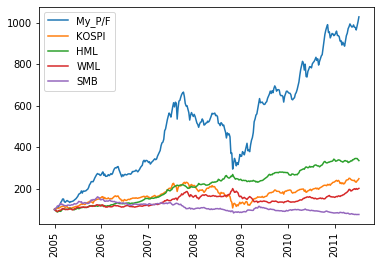

,2005-01-01_To_2011-07-09
Cum_Return,9.284908
Ann_Return,0.429659
Ann_Std,0.249576
Ann_Sharp,1.651434
MDD,-0.509868


In [54]:
plotting_backtest(df0)
Res0

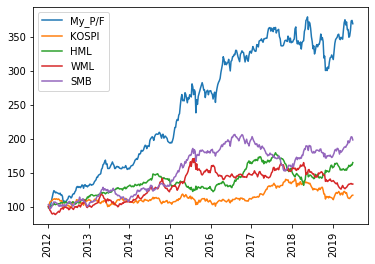

,2012-01-07_To_2019-06-29
Cum_Return,2.692248
Ann_Return,0.190821
Ann_Std,0.154029
Ann_Sharp,1.125250
MDD,-0.208477


In [55]:
plotting_backtest(df)
Res

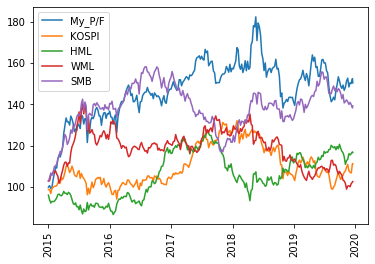

,2015-01-03_To_2019-12-16
Cum_Return,0.504354
Ann_Return,0.085934
Ann_Std,0.158933
Ann_Sharp,0.430587
MDD,-0.241821


In [56]:
plotting_backtest(df1)
Res1

In [57]:
def All_strategy(cleaned_data,cleaned_price, start_day = '2013-1-1' , backtest_period = 4,   rebalance_num = 20,my_money = 100000 , total_num_of_equity = 50) :
    my_lst = [Graham_lastpresent,NCAV, small_lowpbr, Fama_LSV, kang_super_value, new_magic_formula, Value_Quality_Momentum]
    df_lst = []
    R_lst = []
    for i in my_lst :
        df_lst.append(backtest(cleaned_data, cleaned_price,Strategy  = i, start_day = start_day,
                               backtest_period = backtest_period,   rebalance_num = rebalance_num ,
                               initial_money = int(my_money/len(my_lst)) , num_of_equity = int(total_num_of_equity/len(my_lst)) ))
    s = 0
    Total_value = df_lst[0][0].copy()
    for i in df_lst[1:] :
        Total_value = Total_value + i[0]
    Cum_Return = (1 + Total_value.pct_change().fillna(0)).cumprod(0) - 1
    Ret =  Total_value.pct_change().fillna(0)
    Ann_Ret = float( Ret.mean() * 52)
    Ann_Std = float(Ret.std() * np.sqrt(52))
    Ann_Sharp = Ann_Ret / Ann_Std
    MDD = (Total_value.rolling(52).min()['My_Port_Value']/ Total_value.rolling(52).mean()['My_Port_Value'] - 1).min()
    Resul = pd.DataFrame([float(Cum_Return.iloc[-1]), Ann_Ret, Ann_Std, Ann_Sharp , MDD] , columns = [str(Total_value.index[0] ).split(' ')[0] + '_to_' + str(Total_value.index[-1] ).split(' ')[0]],index = ['Cum_return','Ann_Return','Ann_std','Sharp','MDD' ]).round(4)
    return Total_value , Resul

In [58]:
TV , Resul = All_strategy(cleaned_data,cleaned_price,start_day = '2005-1-1' , backtest_period = 4,   rebalance_num = 24,my_money = 100000 , total_num_of_equity = 60)

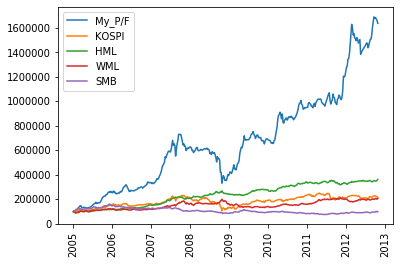

,2005-01-01_to_2012-10-27
Cum_return,15.3621
Ann_Return,0.3885
Ann_std,0.2504
Sharp,1.5515
MDD,-0.4323


In [59]:
plotting_backtest(TV)
Resul

In [60]:
TV2 , Resul2 = All_strategy(cleaned_data, cleaned_price,start_day = '2013-1-1' , backtest_period = 4,   rebalance_num = 20,my_money = 100000 , total_num_of_equity = 50)

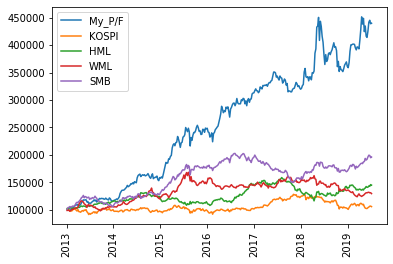

,2013-01-05_to_2019-07-06
Cum_return,3.4017
Ann_Return,0.2439
Ann_std,0.1835
Sharp,1.3293
MDD,-0.2972


In [61]:
plotting_backtest(TV2)
Resul2

In [62]:
TV3 , Resul3 = All_strategy(cleaned_data, cleaned_price,start_day = '2015-1-1' , backtest_period = 4,   rebalance_num = 15,my_money = 100000 , total_num_of_equity = 50)

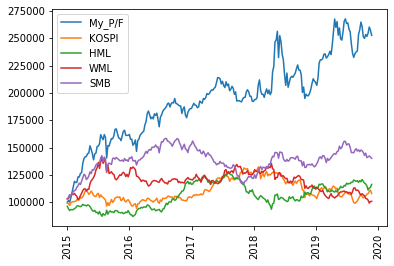

,2015-01-03_to_2019-11-23
Cum_return,1.5279
Ann_Return,0.2092
Ann_std,0.2029
Sharp,1.0313
MDD,-0.3157


In [63]:
plotting_backtest(TV3)
Resul3

In [64]:
def specific_month_effect(path_index , m = [1,2,3,4,11,12],name = 'Nov_to_April') :
    Index_data = preprocessing_price(path_index)
    Index_data.columns = ['KOSPI','KOSDAQ','KOSPI200','KOSDAQ150','S&P','NIKKEI','CHINA','EU']
    Index_data =  Index_data[['KOSPI','KOSDAQ','S&P','NIKKEI','CHINA','EU']]
    Index_return = Index_data.pct_change().iloc[1:]
    R = Index_return.resample('M').sum()
    def f(x) :
        if x.month in m :
            return True
        else :
            return False
    
    R[name] = list(pd.Series(R.index).apply(f))
    newR = R.groupby(name).mean()
    newR['AVERAGE'] = newR.mean(1)
    return newR
    

In [65]:
specific_month_effect(path_index , m = [1,2,3,4,11,12],)

,KOSPI,KOSDAQ,S&P,NIKKEI,CHINA,EU,AVERAGE
Nov_to_April,,,,,,,
False,-0.003973,-0.017170,-0.000569,-0.006709,0.000487,-0.005884,-0.005636
True,0.015297,0.014081,0.009684,0.012808,0.008246,0.007952,0.011345


In [66]:
def preprocessing_Ray_Dalio(path_ray) :
    data = pd.read_excel(path_ray).iloc[7:]
    data = data[list(data.columns[1:2]) + list(data.columns[4:5]) + list(data.columns[6:])]
    data.columns = data.iloc[0]
    data = data.iloc[1:]
    
    data = data.set_index('Symbol Name')
    data.index.name = ''
    data = data.drop(data.columns[0],axis = 1  )
    data = data.dropna(axis = 0 , how= 'all').T
    data.columns = ['KOSPI','S&P500','EUROSTOXX50','NIKKEI225','CHINA','GBOND_ZERO','GBOND_CALL','DOLLAR','GOLD','WTI']
    data.index = pd.to_datetime(data.index)
    data.index.name = ''
    return data.loc['2004-06-18':]

In [67]:
def Backtest_Ray_Dalio(path_ray ,initial_money = 100,div_ratio = 0.0185) :
    ray_data = preprocessing_Ray_Dalio(path_ray)
    div_return = div_ratio / int(365/(ray_data.index[1] - ray_data.index[0]).days)
    
    Equity_Return = (ray_data.pct_change() + div_return).fillna(0)[['KOSPI','S&P500','EUROSTOXX50','NIKKEI225','CHINA']]
    Bond_Return = ray_data.pct_change().fillna(0)[['GBOND_CALL']]
    Dollar_Return = ray_data.pct_change().fillna(0)[['DOLLAR']]
    Gold_Return = ray_data.pct_change().fillna(0)[['GOLD']]
    Oil_Return = ray_data.pct_change().fillna(0)[['WTI']]
    
    Equity_Cum_Ret = initial_money*0.35 *(1 + Equity_Return.mean(1)).cumprod(0)
    Bond_Cum_Ret = initial_money * 0.45 * ( 1 +Bond_Return.mean(1)).cumprod(0)
    Dollar_Cum_Ret = initial_money * 0.05 * ( 1 +Dollar_Return.mean(1)).cumprod(0)
    Gold_Cum_Ret = initial_money * 0.05 * ( 1 +Gold_Return.mean(1)).cumprod(0)
    Oil_Cum_Ret = initial_money * 0.05 * ( 1 +Oil_Return.mean(1)).cumprod(0)
    Cash_Cum_Ret = pd.DataFrame([], index = ray_data.index, columns = ['Cash'])
    
    Cash_Cum_Ret['Cash'] = initial_money * 0.05
    My_Cum_Ret = Equity_Cum_Ret + Bond_Cum_Ret + Dollar_Cum_Ret + Gold_Cum_Ret + Oil_Cum_Ret + Cash_Cum_Ret['Cash']
    My_Ret = My_Cum_Ret.diff().fillna(0)/initial_money
    Ann_Ret = My_Ret.resample('M').sum().mean() * 12
    Ann_Std = My_Ret.resample('M').sum().std() * np.sqrt(12)
    Ann_Sharp = (Ann_Ret - 0.02) / Ann_Std
    MDD = (My_Cum_Ret.rolling(51).min()  / My_Cum_Ret.shift(52)).min()-1 
    
    plt.plot(My_Cum_Ret, label = 'Ray_Dalio')
    plt.plot(initial_money*(1+Equity_Return["KOSPI"]).cumprod(0), label = 'KOSPI')
    plt.legend(loc = 'upper left')
    plt.show()

    Res = pd.DataFrame([Ann_Ret,Ann_Std,Ann_Sharp,MDD], index = ['Ann_Ret','Ann_Std','Ann_Sharp','MDD'], columns= ['Ray_Dalio'])
    
    return My_Cum_Ret, Res

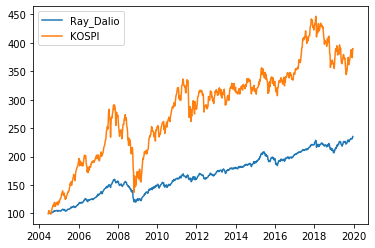

,Ray_Dalio
Ann_Ret,0.086776
Ann_Std,0.121496
Ann_Sharp,0.549616
MDD,-0.246572


In [68]:
A,B = Backtest_Ray_Dalio(path_ray)
B

In [69]:
def backtest_11_4_index(ray_data , start_day = '2004-06-19' ,backtest_period = 4,rebalance_num = 4, initial_money = 100,e_ratio = 0.95,div_ratio = 0.0175) :
    
    
    div_return = div_ratio / int(365/(ray_data.index[1] - ray_data.index[0]).days)

    my_pf = pd.DataFrame()

    endtime , Equity_Ratio, Bond_Ratio, Inverse_Ratio = define_end_day(start_day ,backtest_period = backtest_period , e_ratio = e_ratio, i_ratio = 0)
    for i in range(rebalance_num) :
        new_data = ray_data.loc[start_day : endtime]
        Equity_Return = (new_data.pct_change() + div_return).fillna(0)[['KOSPI','S&P500','EUROSTOXX50','NIKKEI225','CHINA']]
        Bond_Return = new_data.pct_change().fillna(0)[['GBOND_CALL']]
        Equity_Cum_Ret = initial_money*Equity_Ratio *(1 + Equity_Return.mean(1)).cumprod(0)
        Bond_Cum_Ret = initial_money * Bond_Ratio * ( 1 +Bond_Return.mean(1)).cumprod(0)
        Cash_Cum_Ret = pd.DataFrame([], index = new_data.index, columns = ['Cash'])
        Cash_Cum_Ret['Cash'] = initial_money *(1- Equity_Ratio- Bond_Ratio)
        My_Cum_Ret = Equity_Cum_Ret + Bond_Cum_Ret + Cash_Cum_Ret['Cash']
        initial_money = float(My_Cum_Ret.iloc[-1])
        start_day = str(My_Cum_Ret.index[-1]).split(' ')[0]
        endtime , Equity_Ratio, Bond_Ratio, Inverse_Ratio = define_end_day(start_day ,backtest_period = backtest_period ,e_ratio =  e_ratio, i_ratio = 0)
        my_pf = pd.concat([my_pf, My_Cum_Ret] , axis = 0)

    my_pf = my_pf.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')

    my_pf.columns = ['My_Port_Value']
    n = (my_pf.index[-1] - my_pf.index[0]).days/365
    Cum_Return = float((my_pf.iloc[-1] / my_pf.iloc[0])-1)
    My_Port_Return = float(  (my_pf.iloc[-1] / my_pf.iloc[0]) **(1/n) -1  )
    My_Port_Std = float(my_pf.pct_change().iloc[1:].std().round(5)) * np.sqrt(52)
    min_pf = my_pf.rolling(52).min()
    min_pf.columns = ['Min']
    
    shift_my_pf = my_pf.shift(52)
    shift_my_pf.columns = ['before_value']    
    
    
    MDD = (min_pf['Min'] / shift_my_pf['before_value'] - 1).min()
    Ann_Sharp = (My_Port_Return - 0.0175)/My_Port_Std
    result = pd.DataFrame([Cum_Return, My_Port_Return, My_Port_Std, Ann_Sharp, MDD], index = ['Cum_Return','Ann_Return','Ann_Std','Ann_Sharp','MDD'])
    result.columns = [str(my_pf.index[0])[:10] + '_To_'+str(my_pf.index[-1])[:10]]
    return my_pf, result

In [70]:
ray_data = preprocessing_Ray_Dalio(path_ray)

In [71]:
a,b = backtest_11_4_index(ray_data , start_day = '2004-06-19' ,backtest_period = 4,rebalance_num = 4, initial_money = 100,e_ratio = 0.95) 

In [75]:
def plotting_11_4_backtest(ray_data , start_day = '2004-06-19' ,backtest_period = 4,rebalance_num = 4, initial_money = 100,e_ratio = 0.95 , div_ratio = 0.0175) :
    a,b = backtest_11_4_index(ray_data = ray_data , start_day = start_day ,backtest_period = backtest_period,rebalance_num = rebalance_num, initial_money = initial_money,e_ratio = e_ratio) 
    div_return = div_ratio / int(365/(ray_data.index[1] - ray_data.index[0]).days)
    my_pf = initial_money * (1 + (ray_data.pct_change() + div_return).fillna(0)[['KOSPI','S&P500','EUROSTOXX50','NIKKEI225','CHINA']].mean(1)).cumprod(0)
    my_pf = my_pf.loc[a.index[0]:a.index[-1]]
    
    plt.plot(a[a.columns[0]], label = '11_4_strategy')
    plt.plot(my_pf, label = 'Equal_Weighted_Index')
    plt.legend(loc = 'upper left')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    my_pf = pd.DataFrame(my_pf)
    n = (my_pf.index[-1] - my_pf.index[0]).days/365
    Cum_Return = float((my_pf.iloc[-1] / my_pf.iloc[0])-1)
    My_Port_Return = float(  (my_pf.iloc[-1] / my_pf.iloc[0]) **(1/n) -1  )
    My_Port_Std = float(my_pf.pct_change().iloc[1:].std()) * np.sqrt(52)
    min_pf = my_pf.rolling(52).min()
    min_pf.columns = ['Min']
    
    shift_my_pf = my_pf.shift(52)
    shift_my_pf.columns = ['before_value']    
    
    
    MDD = (min_pf['Min'] / shift_my_pf['before_value'] - 1).min()
    Ann_Sharp = (My_Port_Return - 0.0175)/My_Port_Std
    result = pd.DataFrame([Cum_Return, My_Port_Return, My_Port_Std, Ann_Sharp, MDD], index = ['Cum_Return','Ann_Return','Ann_Std','Ann_Sharp','MDD'])
    result.columns = [str(my_pf.index[0])[:10] + '_To_'+str(my_pf.index[-1])[:10]]    
    b.index.name = '11_4_strategy'
    result.index.name = 'Equal_Weighted_Index'
    return b, result

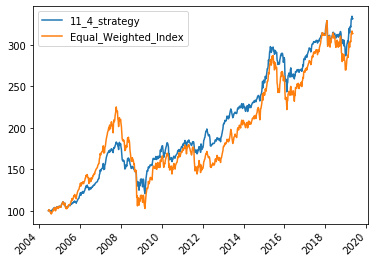

,2004-06-19_To_2019-05-04
Equal_Weighted_Index,
Cum_Return,2.134890
Ann_Return,0.079800
Ann_Std,0.153198
Ann_Sharp,0.406663
MDD,-0.518896


In [76]:
a,b = plotting_11_4_backtest(ray_data , start_day = '2004-06-19' ,backtest_period = 4,rebalance_num = 65, initial_money = 100,e_ratio = 0.95)
b

In [77]:
a

,2004-06-19_To_2019-05-04
11_4_strategy,
Cum_Return,2.312616
Ann_Return,0.083809
Ann_Std,0.109104
Ann_Sharp,0.607756
MDD,-0.316028


In [78]:
def backtest_11_4_portfolio(cleaned_data, cleaned_price,hedge_data, Strategy , start_day , backtest_period , rebalance_num , initial_money = 10000 ,  num_of_equity = 30,fee = 0.005,e_ratio = 0.95, i_ratio = 0   ) :
    hedge_data = hedge_data
    hedge_data.columns = ['인버스','채권']
    
    Inverse_Asset = hedge_data['인버스']
    Bond_Asset = hedge_data['채권']
    
    num = num_of_equity
    rebalance = rebalance_num
    Str = Strategy
    endtime1 = parse(start_day) + datetime.timedelta(days = int(30.416 * backtest_period))
    my_pf = pd.DataFrame()
    
    x =  define_end_day(start_day ,backtest_period , e_ratio , i_ratio ) 
    
    endtime1 = x[0]
    Equity_Ratio = x[1]
    Bond_Ratio = x[2]
    Inverse_Ratio  =x[3]
    
    for i in range(rebalance) :
        date = How_date(start_day)
        
        if Str == momentum :
            day = start_day
            Str_data = Str( cleaned_price , day= start_day , num = num)
        elif Str == Residual_Momentum :
            day = start_day 
            Str_data = Str(cleaned_price, path_factor1,day = start_day,num = num )
        elif Str == Value_Quality_Momentum:
            day = start_day
            Str_data = Str(cleaned_data,cleaned_price, date, day = start_day, num = num) 
        else : 
            Str_data = Str(cleaned_data, date, num = num)    
        
        lst = list(Str_data.index)
    
        price_data = cleaned_price.loc[start_day : endtime1]
        bond_data = Bond_Asset.loc[start_day : endtime1]
        inverse_data = Inverse_Asset.loc[start_day : endtime1]
        My_Equity_Value = (initial_money*Equity_Ratio* (1 + (price_data[lst].pct_change().fillna(0)).mean(1)).cumprod(0))
        My_Bond_Value = initial_money * Bond_Ratio * (1 + bond_data.pct_change().fillna(0)).cumprod(0)
        My_Inverse_Value = initial_money * Inverse_Ratio * (1 + inverse_data.pct_change().fillna(0)).cumprod(0)    
        if len(lst) == 0 :
            print('Yes')
            Temp_price_data = pd.DataFrame(price_data[lst], columns = [0])
            Temp_price_data[0] = initial_money * Equity_Ratio * (1 + bond_data.pct_change().fillna(0)).cumprod(0)
            My_Equity_Value = Temp_price_data[0]
        my_pf_value = My_Equity_Value + My_Bond_Value + My_Inverse_Value
        end_money = float(my_pf_value.iloc[-1] * (1-fee))
        start_day = str(my_pf_value.index[-1]).split(' ')[0]        
        initial_money = end_money
        
        x = define_end_day(start_day , backtest_period, e_ratio = e_ratio, i_ratio = i_ratio)
        endtime1 = x[0]
        Equity_Ratio = x[1]
        Bond_Ratio = x[2]
        Inverse_Ratio  =x[3]
        my_pf = pd.concat([my_pf , my_pf_value.iloc[:]], axis = 0)
    my_pf = my_pf.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')

    my_pf.columns = ['My_Port_Value']
    n = (my_pf.index[-1] - my_pf.index[0]).days/365
    Cum_Return = float((my_pf.iloc[-1] / my_pf.iloc[0])-1)
    My_Port_Return = float(  (my_pf.iloc[-1] / my_pf.iloc[0]) **(1/n) -1  )
    My_Port_Std = float(my_pf.pct_change().iloc[1:].std().round(5)) * np.sqrt(52)
    min_pf = my_pf.rolling(52).min()
    min_pf.columns = ['Min']
    
    shift_my_pf = my_pf.shift(52)
    shift_my_pf.columns = ['before_value']    
    
    
    MDD = (min_pf['Min'] / shift_my_pf['before_value'] - 1).min()
    Ann_Sharp = (My_Port_Return - 0.0175)/My_Port_Std
    result = pd.DataFrame([Cum_Return, My_Port_Return, My_Port_Std, Ann_Sharp, MDD], index = ['Cum_Return','Ann_Return','Ann_Std','Ann_Sharp','MDD'])
    result.columns = [str(my_pf.index[0])[:10] + '_To_'+str(my_pf.index[-1])[:10]]
    return my_pf, result         

In [79]:
a,b = backtest_11_4_portfolio(cleaned_data,cleaned_price,hedge_data,Value_Quality_Momentum, start_day = '2015-1-11' ,
                            backtest_period = 4 , rebalance_num =22,
                            initial_money = 10000 ,  num_of_equity = 30,fee = 0.005,e_ratio = 0.60, i_ratio = 0.25)

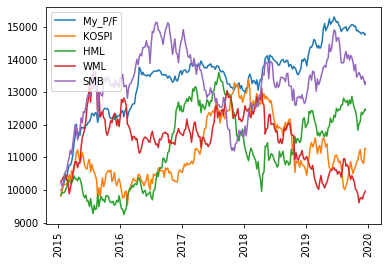

,2015-01-17_To_2019-12-16
Cum_Return,0.476792
Ann_Return,0.082553
Ann_Std,0.067063
Ann_Sharp,0.970019
MDD,-0.068947


In [80]:
plotting_backtest(a)
b